In [1]:
from pathlib import Path
# import nfp
import numpy as np
import pandas as pd
import tarfile
from pymatgen.core import Structure
import json
import gzip
from glob import glob
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

## Data Exploration

### Check prototype structures
Double check that the prototype structures don't have atoms in the same positions

In [3]:
def get_structures(filename, ids=None):
    with gzip.open(Path(structure_dir, filename), 'r') as f:
        data = json.loads(f.read().decode())
        
        if ids is None:
            ids = data.keys()
            
        for key in tqdm(ids):
            if key in data:
                yield {'id': key, 'structure': Structure.from_dict(data[key])}        

In [4]:
from nfp.preprocessing.crystal_preprocessor import PymatgenPreprocessor
from pymatgen.core import Structure
preprocessor = PymatgenPreprocessor()

def preprocess_structure(structure):
    scaled_struct = structure.copy()
    inputs = preprocessor(scaled_struct, train=True)

    # scale structures to a minimum of 1A interatomic distance
    min_distance = inputs["distance"].min()
    if np.isclose(min_distance, 0):
        raise RuntimeError(f"Error with {structure}")

    inputs["distance"] /= inputs["distance"].min()
    return inputs

2022-03-11 17:04:37.723932: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /nopt/slurm/current/lib:
2022-03-11 17:04:37.723965: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
structure_dir = Path('/projects/rlmolecule/jlaw/inputs/structures/')
calc_energy = pd.read_csv(Path(structure_dir, 'battery_relaxed_energies.csv'))

In [6]:
protos_file = "/home/jlaw/projects/arpa-e/crystals/rlmolecule/rlmolecule/crystal/inputs/icsd_prototypes.json.gz"
proto_strcs = pd.DataFrame(get_structures(protos_file))
proto_strcs.columns = ['rlcrystal_id', 'structure']
proto_strcs.head(2)

  0%|          | 0/4170 [00:00<?, ?it/s]

,rlcrystal_id,structure
0,_1_1_1_2_3|orthorhombic|POSCAR_sg62_icsd_174512,"[[12.70681846 1.413475 0.1000818 ] H, [4.0..."
1,_1_1_1_2_3|orthorhombic|POSCAR_sg70_icsd_079945,"[[ 6.13025 9.783375 17.3280125] K, [ 6.130..."


In [7]:
proto_strcs['id'] = proto_strcs['rlcrystal_id'].apply(lambda x: 'icsd_' + x.split('_')[-1])
proto_strcs = proto_strcs.set_index('id')
proto_strcs.head(2)

,rlcrystal_id,structure
id,,
icsd_174512,_1_1_1_2_3|orthorhombic|POSCAR_sg62_icsd_174512,"[[12.70681846 1.413475 0.1000818 ] H, [4.0..."
icsd_079945,_1_1_1_2_3|orthorhombic|POSCAR_sg70_icsd_079945,"[[ 6.13025 9.783375 17.3280125] K, [ 6.130..."


In [8]:
def is_valid(structure):
    scaled_struct = structure.copy()
    inputs = preprocessor(structure, train=True)

    # check the minimum interatomic distance
    # if it's 0, then one or more atoms occupy the same site
    min_distance = inputs["distance"].min()
    if np.isclose(min_distance, 0):
        return False
    return True

In [112]:
proto_strcs['valid_proto'] = proto_strcs['structure'].progress_apply(is_valid)

2022-03-11 10:17:33.669531: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /nopt/slurm/current/lib:
2022-03-11 10:17:33.671545: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /nopt/slurm/current/lib:
2022-03-11 10:17:33.672708: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /nopt/slurm/current/lib:
2022-03-11 10:17:33.674057: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared 

In [132]:
print(f"{len(proto_strcs[proto_strcs['valid_proto'] == True])} / {len(proto_strcs)} valid prototype structures")

4144 / 4170 valid prototype structures


In [9]:
battery_structures_volrelaxed = pd.DataFrame(get_structures('volrelax/battery_relaxed_vol_structures.json.gz')).set_index('id')
battery_structures_volunrelaxed = pd.DataFrame(get_structures('volrelax/battery_unrelaxed_vol_structures.json.gz')).set_index('id')
battery_structures_relaxed = pd.DataFrame(get_structures('battery_relaxed_structures.json.gz')).set_index('id')
battery_structures_unrelaxed = pd.DataFrame(get_structures('battery_unrelaxed_structures.json.gz')).set_index('id')

  0%|          | 0/30324 [00:00<?, ?it/s]

  0%|          | 0/30522 [00:00<?, ?it/s]

  0%|          | 0/67840 [00:00<?, ?it/s]

  0%|          | 0/67840 [00:00<?, ?it/s]

In [136]:
# check how many have a valid prototype structure
battery_structures_volrelaxed['proto_id'] = battery_structures_volrelaxed.index.map(lambda x: 'icsd_' + x.split('_')[-2])
df_volrel = battery_structures_volrelaxed.merge(proto_strcs['valid_proto'], left_on='proto_id', right_index=True, how='inner')
df_volrel.head(2)

,structure,proto_id,valid_proto
id,,,
Zn1La3I2P3_sg189_icsd_076297_1,"[[1.55036141 2.68529936 0. ] La, [4.580...",icsd_076297,True
Zn1La3I2P3_sg189_icsd_076297_2,"[[1.60535746 2.78056045 0. ] P, [4.7425...",icsd_076297,True


In [137]:
df_volrel['valid_proto'].sum()

30241

In [139]:
df_volrel['valid_strc'] = df_volrel['structure'].progress_apply(is_valid)

  0%|          | 0/30324 [00:00<?, ?it/s]

In [146]:
print(f"{len(df_volrel[df_volrel['valid_strc'] == True])} / {len(df_volrel)} are valid")

30245 / 30324 are valid


In [148]:
df_volrel[df_volrel['valid_strc'] == False]['proto_id'].value_counts()

icsd_158336    16
icsd_107859    15
icsd_038443    12
icsd_065634    12
icsd_246867    10
icsd_607870    10
icsd_044995     4
Name: proto_id, dtype: int64

In [147]:
df_volrel.loc['Mg3F2O2_sg15_icsd_158336_2']

structure      [[-0.033255  3.541605  0.      ] O, [0. 0. 0.]...
proto_id                                             icsd_158336
valid_proto                                                False
valid_strc                                                 False
Name: Mg3F2O2_sg15_icsd_158336_2, dtype: object

In [ ]:
battery_structures_volunrelaxed['proto_id'] = battery_structures_volunrelaxed.index.map(lambda x: 'icsd_' + x.split('_')[-2])
df_volunrel = battery_structures_volunrelaxed.merge(proto_strcs['valid_proto'], left_on='proto_id', right_index=True, how='inner')

In [11]:
# load the energies
df = pd.read_csv("/projects/rlmolecule/jlaw/inputs/structures/volrelax/battery_volrelaxed_energies.csv")
print(len(df))
df.head(2)

26006


,comp_type,composition,id,energyperatom
0,_1_1_2_5,K5Hg1I1N2,K5Hg1I1N2_sg194_icsd_033805_2,-0.176
1,_1_1_2_5,K5Hg1I1N2,K5Hg1I1N2_sg26_icsd_059680_1,-2.092


<AxesSubplot:>

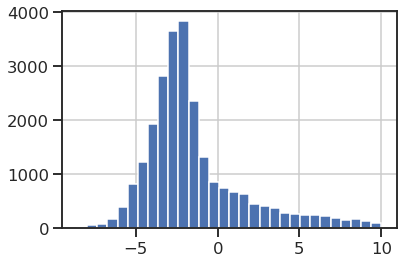

In [12]:
# limit to -10 to 10 eV/atom 
df = df[(df['energyperatom'] > -10) & (df['energyperatom'] < 10)]
df['energyperatom'].hist(bins=30)

<AxesSubplot:>

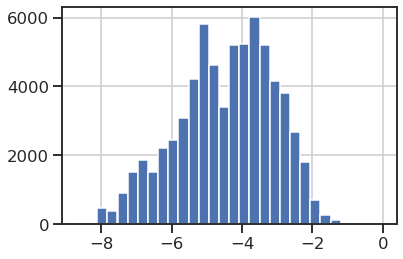

In [159]:
# compare distribution to DFT relaxed structures
calc_energy.energyperatom.hist(bins=30)

In [87]:
len(df)

24863

In [10]:
# filter out structures that have atoms at the same position
# the above "min_distance == 0" filter was applied to this all_data.p file
from pathlib import Path
inputs_dir = Path("../outputs/20220309_volrelax")
data = pd.read_pickle(Path(inputs_dir, "all_data.p"))

In [85]:
data.head(2)

,comp_type,composition,id,energyperatom,inputs
0,_1_1_2_5,K5Hg1I1N2,K5Hg1I1N2_sg194_icsd_033805_2,-0.176,"{'site': [7, 7, 7, 7, 4, 4, 4, 4, 10, 10, 10, ..."
1,_1_1_2_5,K5Hg1I1N2,K5Hg1I1N2_sg26_icsd_059680_1,-2.092,"{'site': [4, 4, 7, 7, 10, 10, 10, 10, 10, 10, ..."


In [94]:
print(f"{len(data)} / {len(df_volrel)} structures have DFT energy and pass min-dist filter")

25769 / 30324 structures pass the min distance filter


<AxesSubplot:>

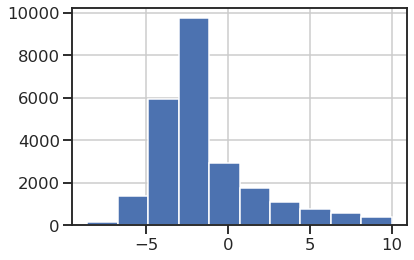

In [88]:
data = data[(data['energyperatom'] > -10) & (data['energyperatom'] < 10)]
data['energyperatom'].hist()

In [89]:
len(data)

24674

In [ ]:
# write to a different energies file
#df = pd.read_csv("/projects/rlmolecule/jlaw/inputs/structures/volrelax/battery_volrelaxed_energies_.csv")
#df.head(2)

In [153]:
strc = Structure.from_file("/projects/rlmolecule/jlaw/inputs/structures/volrelax/_1_3/Li3N1/Li3N1_sg221_icsd_652775_1/POSCAR")
strc

/lustre/eaglefs/projects/rlmolecule/jlaw/envs/crystals_nfp0_3/lib/python3.8/site-packages/pymatgen/io/vasp/inputs.py:394: UserWarning: Elements in POSCAR cannot be determined. Defaulting to false names H H H He.
  warnings.warn(


Structure Summary
Lattice
    abc : 4.719 4.719 4.719
 angles : 90.0 90.0 90.0
 volume : 105.08722695900003
      A : 4.719 0.0 0.0
      B : 0.0 4.719 0.0
      C : 0.0 0.0 4.719
PeriodicSite: H (2.3595, 2.3595, 0.0000) [0.5000, 0.5000, 0.0000]
PeriodicSite: H (2.3595, 0.0000, 2.3595) [0.5000, 0.0000, 0.5000]
PeriodicSite: H (0.0000, 2.3595, 2.3595) [0.0000, 0.5000, 0.5000]
PeriodicSite: He (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]